# Clustering

For this project, we want to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

### Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li> Do not use the targets from the dataset at all. 
    <li> Use as many clusters as you think is appropriate.
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li><b>So, to this point. You take the images, ditch their labels, and do clustering to group them. You don't know which cluster is which digit. You have to then label them, or look at each one and say, "looks like 7s", then assign that group a label of 7. </b>
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. Each digit should be a new generation of data.</b>
</ul>

### Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits.

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import math

In [2]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
#mnist = mnist[0:15000]
X = mnist["data"]
print(X.shape)

(70000, 784)


## Cluster 

We need to break the data into clusters first... 

In [3]:
# Cluster data using KMeans model without PCA. We already know we have 10 digits so 10 clusters needed
#This will be a first trial to see what the result would be like
num_clus = 10
kmeans = KMeans(num_clus, random_state=0)
kmeans.fit(X)
clusters = pd.Series(kmeans.labels_)
clusters.shape

(70000,)

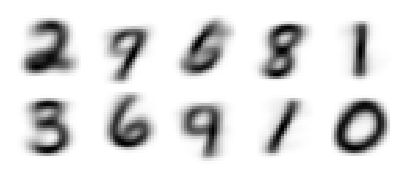

In [4]:
# Plot the center of the clusters to visualize the data
fig, ax = plt.subplots(2, 5, figsize=(5, 2))
centers = kmeans.cluster_centers_.reshape(num_clus, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.axis('off')
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
plt.subplots_adjust(wspace=0, hspace=0 )

In [5]:
# Combime the digit data (X) and the cluster labels, into 1 data frame
clusters = pd.Series(kmeans.labels_, name='clusters')
clusters = clusters.to_frame()
df = pd.merge(X, clusters, left_index=True, right_index=True)
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,clusters
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


From the above view of the center of the clusters, we see that the the clustering was able to distinctly identify some of the numbers. However, the numbers 4 and 7 are not quite easily discernable from the above plots. We will also plot some random rows from each cluster to ascertaiin what figures they are

In [6]:
# We write a function to help with visualizing sample digits from different clusters

def viewCluster(cluster_label, data, n_samples=30):
    import math
     
    col = 5
    row = math.ceil(n_samples/col)
    fig, ax = plt.subplots(row, col, figsize=(row, col))
    
    samples_index = data.clusters[data.clusters==cluster_label].sample(n_samples).index
    samples = data.iloc[samples_index, 0:784]
    samples = np.array(samples).reshape(n_samples, 28,28)
    
    for axi, sample in zip(ax.flat, samples):
        axi.axis('off')
        axi.imshow(sample, interpolation='nearest', cmap=plt.cm.binary)
    plt.subplots_adjust(wspace=0, hspace=0 )

In [7]:
# Function clusterView() below is a widget function to help with visualization of the various clusters in tabs
def clusterView(n_cluster, data):
    import ipywidgets as widgets
    
    #initiate the widget objects into a list
    outs = [widgets.Output() for i in range(n_cluster)]
    tab = widgets.Tab(children = outs)
    
    #Set the title of each widget tab
    for i in range(n_cluster):    
        title = 'Clu-'+ str(i)
        tab.set_title(i, title)
    display(tab)
    
    for i in range(n_cluster):
        with outs[i]:
            fig = viewCluster(i, data)
            plt.show(fig)

In [8]:
# Let's visualize samples of the clusters to see what digits are contained in each cluster
clusterView(num_clus, data=df)

From the above visualization of the clusters, we can see that while some of the clusters show a clean grouping of certain digits, some other clusters are a mix-match. To try to improve this, we will increase the number o clusters in our model .

## Exploring number of clusters for improvement

Centers for 10 clusters:


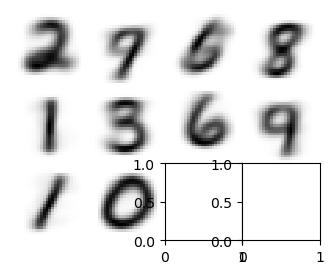

Centers for 12 clusters:


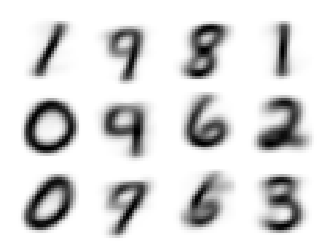

Centers for 14 clusters:


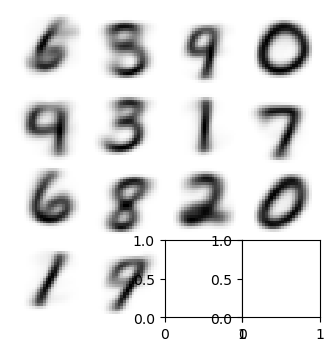

Centers for 16 clusters:


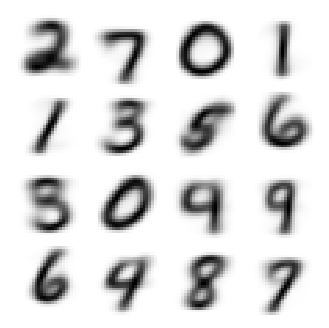

In [9]:
num_clus = [10, 12, 14, 16]
for c in num_clus:
    kmeans = KMeans(n_clusters=c, random_state=0)
    kmeans.fit(X)
    clusters = pd.Series(kmeans.labels_)
    
    col = 4
    row = math.ceil(c/col)
    fig, ax = plt.subplots(row, col, figsize=(col, row))
    centers = kmeans.cluster_centers_.reshape(c, 28, 28)
    print(f'Centers for {c} clusters:')
    for axi, center in zip(ax.flat, centers):
        axi.axis('off')
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
    plt.subplots_adjust(wspace=0, hspace=0 )
    plt.show()

From the above view of the centers of various clusters, we can see some improvements in the digits identified as the number of clusters increased. For example we see that with 10 clusters, we couldn't identify 4 and 7 at all while 5 was also not clear; with 14 clusters, we were able to identify the digit 7 clearly but lost digit 5; and with 16 clusters, we are able to see some faint resemblance of the digit 4.
We will therefore settle on using 16 clusters to group the data. 

Next we visualize samples of each cluster in the clustered group to be able to label each one appropriately

In [10]:
# Let's now create a model with 16 clusters
num_clus = 16
kmeans = KMeans(num_clus, random_state=0)
kmeans.fit(X)

# Combime the digit data (X) and the cluster labels, into 1 data frame
clusters = pd.Series(kmeans.labels_, name='clusters')
clusters = clusters.to_frame()
df1 = pd.merge(X, clusters, left_index=True, right_index=True)

In [11]:
#View samples
clusterView(num_clus, data=df1)

In [12]:
# Set the digits for the clusters using digits 0 - 10.
# 10 represents every other cluster that contains digits not well classified
df1['digit'] = 0
df1['digit'][df1.clusters==0] = 2
df1['digit'][df1.clusters==1] = 7
df1['digit'][df1.clusters==2] = 0
df1['digit'][df1.clusters==3] = 10
df1['digit'][df1.clusters==4] = 1
df1['digit'][df1.clusters==5] = 3
df1['digit'][df1.clusters==6] = 5
df1['digit'][df1.clusters==7] = 6
df1['digit'][df1.clusters==8] = 10
df1['digit'][df1.clusters==9] = 0
df1['digit'][df1.clusters==10] = 10
df1['digit'][df1.clusters==11] = 9
df1['digit'][df1.clusters==12] = 6
df1['digit'][df1.clusters==13] = 4
df1['digit'][df1.clusters==14] = 8
df1['digit'][df1.clusters==15] = 10

C:\Users\adeni\AppData\Local\Temp\ipykernel_21880\2363846081.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['digit'][df1.clusters==0] = 2
C:\Users\adeni\AppData\Local\Temp\ipykernel_21880\2363846081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['digit'][df1.clusters==1] = 7
C:\Users\adeni\AppData\Local\Temp\ipykernel_21880\2363846081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['digit'][df1.clusters==2] = 

## Generating Digits from clusters


In [13]:
def writeNumber(num):
    # Convert number to list of digits
    try: 
        num_digits = [int(i) for i in str(num)]
    except:
        print('Error! Your parameter is not all digits')
    else:
        digit_reps = []
        for digit in num_digits:
            digit_rep = df1[df1['digit']==digit].drop(['clusters','digit'], axis=1).sample()
            digit_reps.append(digit_rep)

        # Plot the center of the clusters to visualize the data
        col = len(num_digits)
        if col == 1:
            fig, ax = plt.subplots(figsize=(1,1))
            ax.imshow(np.array(digit_reps[0]).reshape(28, 28), interpolation='nearest', cmap=plt.cm.binary)
            ax.axis('off')
        else:
            fig, ax = plt.subplots(1, col)
            digit_reps = np.array(digit_reps).reshape(col, 28, 28)
            for axi, digit in zip(ax.flat, digit_reps):
                axi.axis('off')
                axi.imshow(digit, interpolation='nearest', cmap=plt.cm.binary)

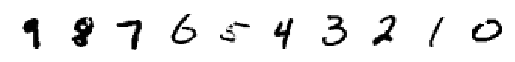

In [14]:
writeNumber(9876543210)

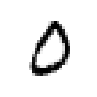

In [15]:
writeNumber(0)

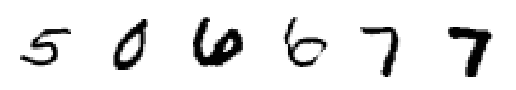

In [16]:
writeNumber(556677)